In [19]:
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d')
end_date = datetime.now()
period = 86400

def get_crypto_data(poloniex_pair):
    poloniex_pair = "BTC_{}".format(poloniex_pair)
    json_url = base_polo_url.format(
        poloniex_pair,
        start_date.timestamp(),
        end_date.timestamp(),
        period
    )
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

def get_json_data(json_url, cache_path):
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
        return df
    
def create_dataset(dataset, lookback=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset) - lookback):
        dataY.append(dataset[i+lookback, 0])
        dataX.append(dataset[i])
    return np.array(dataX), np.array(dataY)

def train_test_split(data, test_size=0.2):
    train_set_size = int(len(data) * (1-test_size))
    train_set = data[:train_set_size]
    test_set = data[-(len(data)-train_set_size):]
    return train_set, test_set

ticker = "LSK"
ds = get_crypto_data(ticker)
ds = ds['close'].dropna(how='all')
ds = ds.values.reshape(len(ds), 1)

scaler = MinMaxScaler(feature_range=(0,1))
ds = scaler.fit_transform(ds)

train, test = train_test_split(ds)

look_back=1

X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(8, input_shape=(1, look_back), dropout=0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=23, batch_size=1, verbose=2)

model_json = model.to_json()
with open("model_{}.json".format(ticker), "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_{}.h5".format(ticker))

Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LSK&start=1420088400.0&end=1511724876.410173&period=86400 at BTC_LSK
Epoch 1/23
 - 3s - loss: 0.0238
Epoch 2/23
 - 2s - loss: 0.0133
Epoch 3/23
 - 2s - loss: 0.0139
Epoch 4/23
 - 2s - loss: 0.0105
Epoch 5/23
 - 2s - loss: 0.0122
Epoch 6/23
 - 3s - loss: 0.0122
Epoch 7/23
 - 2s - loss: 0.0103
Epoch 8/23
 - 2s - loss: 0.0099
Epoch 9/23
 - 2s - loss: 0.0111
Epoch 10/23
 - 2s - loss: 0.0115
Epoch 11/23
 - 3s - loss: 0.0100
Epoch 12/23
 - 3s - loss: 0.0091
Epoch 13/23
 - 2s - loss: 0.0090
Epoch 14/23
 - 2s - loss: 0.0088
Epoch 15/23
 - 2s - loss: 0.0114
Epoch 16/23
 - 2s - loss: 0.0071
Epoch 17/23
 - 2s - loss: 0.0107
Epoch 18/23
 - 2s - loss: 0.0076
Epoch 19/23
 - 2s - loss: 0.0096
Epoch 20/23
 - 2s - loss: 0.0065
Epoch 21/23
 - 2s - loss: 0.0090
Epoch 22/23
 - 2s - loss: 0.0079
Epoch 23/23
 - 2s - loss: 0.0059


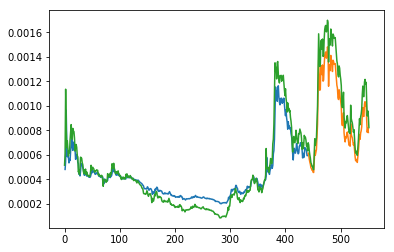

In [29]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+1:len(ds)-1, :] = testPredict

plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.plot(scaler.inverse_transform(ds))
plt.savefig('ptoato.png')
plt.show()

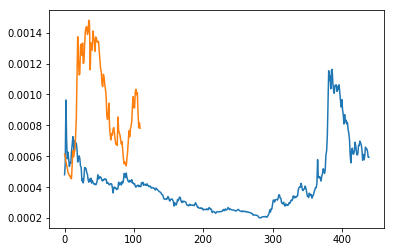

In [30]:
plt.plot(trainPredict)
plt.plot(testPredict)

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model.png')
Image(filename='model.png')

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.